# Local analysis: evaluation of bias in the detection of crest points

*Jacob Kerssemakers, Sabrina Meindlhumer, Cees Dekker lab, 2022*

This notebook expands on the descriptions and definitions introduced in the Notebook 'DEMO_MinDE_local_analysis'. There, we described the identification of wave crests (using optical flow image analysis tools) and frame-wise comparison of crest positions to determine their local propagation speed. Each crest point is associated with coordinates ($x$, $y$) within the field-of-view and a velocity wave vector $\vec{v}$ = ($v_x$, $v_y$). <br>
For obtaining these crest points, we used a flow velocity analysis. For robustness of the method, this analysis was carried out on strongly smoothed image data. Naturally, one may ask how this strong smoothing affects the final velocity analysis, as the true wave maxima may not coincide with the wave maxima of the smoothed wave pattern. Here, we focus in more detail on this possible smoothing bias.

## Setup
Import of standard modules, the used flow field analysis method (Horn-Schunck) and assisting custom-made modules. Needs to be executed at least once to ensure correct functionality (see instructions above).

In [1]:
from pathlib import Path
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from cv2 import filter2D

from pyoptflow import HornSchunck
from min_analysis_tools.get_auto_halfspan import get_auto_halfspan
from min_analysis_tools import get_data, min_de_patterns_crests, peak_profile
from min_analysis_tools.local_velocity_analysis import local_velocity_analysis

plt.rc("font", size=10)  # controls default text size
plt.rcParams.update({"font.family": "arial"})

# Reload modules automatically before executing code
%reload_ext autoreload
%autoreload 2

In [2]:
# save set to True -> selected images saved to save_output
save = False
save_dpi = 150
cm = 1 / 2.54  # centimeters in inches (for matplotlib figure size)

## Select example
Choose an example from the provided stacks in the list below:<br>
(1) Simulated spiral<br>
(2) Min spiral (example data)<br>
(3) Min southeast-directed traveling waves (example data)<br>
(4) Min west-directed traveling waves (example data)<br>
(5) Min large stitched pattern (example data)<br>
(6) Min horizontally stitched pattern (example data)<br>
<br>
Choose the example by setting the variable *selection* in the code-box below. The notebook needs to be re-run (at least from this point onwards) for changes to be applied.

In [3]:
selection = 2  # set to 1 ... 6

In [4]:
if selection not in np.arange(1, 7):
    print("Invalid selection. Set to selection 1 (Simulated spiral).")
    selection = 1
    MinDE_st_original = get_data.generate_pattern(
        lambda_t=20, lambda_x=1, size=512, N_frames=50, demo=False
    )
    zm_lo = 45
    zm_hi = 70
elif selection == 1:  # "Simulated spiral"
    MinDE_st_original = get_data.generate_pattern(
        lambda_t=20, lambda_x=1, size=512, N_frames=50, demo=False
    )
    zm_lo = 45
    zm_hi = 70
elif selection > 1:
    if selection == 2:  # "Min spiral (example data)"
        stack_path = Path().cwd() / "example_data" / "demo_spiral.tif"
        zm_lo = 75
        zm_hi = 100
    if selection == 3:  # "Min southeast-directed traveling waves (example data)"
        stack_path = Path().cwd() / "example_data" / "demo_southeast.tif"
        zm_lo = 75
        zm_hi = 100
    if selection == 4:  # "Min west-directed traveling waves (example data)"
        stack_path = Path().cwd() / "example_data" / "paper_west_E.tif"
        zm_lo = 150
        zm_hi = 175
    if selection == 5:  # "Min large stitched pattern (example data)"
        stack_path = Path().cwd() / "example_data" / "demo_square_stitch.tif"
        zm_lo = 75
        zm_hi = 100
    if selection == 6:  # "Min horizontally stitched pattern (example data)"
        stack_path = Path().cwd() / "example_data" / "demo_horizontal_stitch.tif"
        zm_lo = 65
        zm_hi = 90
    MinDE_st_original = io.imread(stack_path)
nt, ny, nx = np.shape(MinDE_st_original)
auto_halfspan = get_auto_halfspan(
    MinDE_st_original, frames_to_analyse=10, verbose=False
)

print(f"Current selection: {selection}")

Current selection: 2


In [5]:
MinDE_st = min_de_patterns_crests.adjust_stack_orientation(MinDE_st_original)

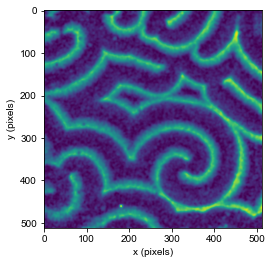

In [6]:
fig, ax = plt.subplots()
ax.imshow(MinDE_st[0, :, :])
ax.set_xlabel("x (pixels)")
ax.set_ylabel("y (pixels)")
plt.show()

In [7]:
halfspan = auto_halfspan  # default: auto_halfspan
sampling_width = 1  # default: 1

## Flow field analysis
We build two smoothed image stacks, first one with a finer smoothing kernel, then one with a rather large kernel. The strongly-smoothed stack (*_smz_flow*) is used only for flow analysis (Horn-Schunck), the lightly-smoothed stack (*_smz*) will later on be used for peak detection.<br>
The value for light and strong smoothing can be set in the code-box below. Changing these values will lead to results of different quality, and optimal values may differ from file to file. The notebook needs to be re-run (at least from this point on) for change to apply.

In [8]:
kernel_size_general = 15  # for general (light) smoothing
kernel_size_flow = 35  # stronger smoothing for optical flow analysis

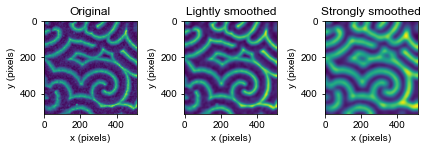

In [9]:
# build kernel for first smoothing step (for processing)
general_kernel = np.ones((kernel_size_general, kernel_size_general), np.float32) / (
    kernel_size_general**2
)

# build kernel for obtaining flow pattern
flow_kernel = np.ones((kernel_size_flow, kernel_size_flow), np.float32) / (
    kernel_size_flow**2
)

# create lightly and strongly smoothed images
im0_raw = MinDE_st[0, :, :]
im1_raw = MinDE_st[1, :, :]
im0_smz = filter2D(im0_raw, -1, general_kernel)
im1_smz = filter2D(im1_raw, -1, general_kernel)
im0_smz_flow = filter2D(im0_smz, -1, flow_kernel)
im1_smz_flow = filter2D(im1_smz, -1, flow_kernel)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(im0_raw)
ax1.set_title("Original")
ax1.set_xlabel("x (pixels)")
ax1.set_ylabel("y (pixels)")
ax2.imshow(im0_smz)
ax2.set_title("Lightly smoothed")
ax2.set_xlabel("x (pixels)")
ax2.set_ylabel("y (pixels)")
ax3.imshow(im0_smz_flow)
ax3.set_title("Strongly smoothed")
ax3.set_xlabel("x (pixels)")
ax3.set_ylabel("y (pixels)")
fig.tight_layout()
plt.show()

In [10]:
flow_x, flow_y = HornSchunck(im0_smz_flow, im1_smz_flow, alpha=100, Niter=100)
wavesign_im = min_de_patterns_crests.get_rise_or_fall(flow_x, flow_y, im0_smz)
(
    crests_x,
    crests_y,
    forward_wavevector_x,  # w_x
    forward_wavevector_y,  # w_y
) = min_de_patterns_crests.get_crests(wavesign_im, im0_smz, halfspan / 2)

(profile_map1, xxgrid, yygrid) = min_de_patterns_crests.sample_crests(
    im0_smz,
    crests_x,
    crests_y,
    forward_wavevector_x,
    forward_wavevector_y,
    halfspan,
    sampling_width,
)
(profile_map2, xxgrid, yygrid) = min_de_patterns_crests.sample_crests(
    im1_smz,
    crests_x,
    crests_y,
    forward_wavevector_x,
    forward_wavevector_y,
    halfspan,
    sampling_width,
)
# profile map of strongly smoothes image, for comparison only:
(profile_map3, xxgrid, yygrid) = min_de_patterns_crests.sample_crests(
    im0_smz_flow,
    crests_x,
    crests_y,
    forward_wavevector_x,
    forward_wavevector_y,
    halfspan,
    sampling_width,
)

## Velocity tracking
The two maps offer two profiles per crest position, one for the current frame (frame 1) and one for the next (frame 2).<br>
For each profile, a sub-unit maximum position is determined by a multi-point parabolic fit around the maximum. Since the cross-section was taken perpendicular to the wave crest, the shift between the two maxima reflects the shift of the crest peak position perpendicular to the local wave orientation. Thus, this shift equals a crest velocity in pixels per frame.<br>

In [11]:
velocities = min_de_patterns_crests.compare_crestmaps(
    profile_map1, profile_map2, sampling_width, look_ahead=1
)

In [12]:
print(f"Determined velocities for {np.size(velocities)} crest points.")
bad_count = 0
bad_indices = []
for ind, vel in enumerate(velocities):
    if not vel >= 0:
        bad_indices.append(int(ind))
        bad_count = bad_count + 1
velocities = np.delete(velocities, bad_indices, 0)
profile_map1 = np.delete(profile_map1, bad_indices, 0)
profile_map2 = np.delete(profile_map2, bad_indices, 0)
xxgrid = np.delete(xxgrid, bad_indices, 0)
yygrid = np.delete(yygrid, bad_indices, 0)
print(f"Discarded {bad_count} peaks due to failed peak detection.")

Determined velocities for 3441 crest points.
Discarded 390 peaks due to failed peak detection.


## Crest point estimation
Below, the profile along the highlighted line will be shown in red for frame 1 and in blue for frame 2. The maximum identified will be shown as black dot. Before, it was explained how this shift, combined with the direction of the cross-section, suffices to obtain a velocity vector <br>
It should be noted that these two profiles are taken from the lightly smoothed image stack (see the examples above). This smoothing is just enough to allow a robust peak detection on smooth peaks. In contrast, the crest  point position itself was obtained from a strongly smoothed movie, the latter being needed for a stable flow pattern analysis. To highlight this difference, we show the profile associated with the crest point detection itself in black. The two levels of smoothing cause the detected, first order estimate of the crest position (i.e., the peak position of the black curve) to deviate from the more detailed peak position (red).  <br> 
We can exepct this deviation to depend on the level of strong smoothing used. However, while the first order estimates should very somewhat, we would expect the final fitting and especially the peak shift, to be not sensitive to this.
We check this assumption by apllying different levels of smoothing, and measuring the avarge shift and its associated spread (as full-width-half-maximum) for different smoothing levels.

Note: The crest index to be shown can be set below (notebook needs to be re-run from this point on for changes to apply).

In [13]:
length = np.shape(profile_map1)[0]
print(
    f"Considered wave crest points: {length} (set crest index to integer number from 0 to {length-1})"
)

Considered wave crest points: 3051 (set crest index to integer number from 0 to 3050)


In [14]:
crest_index = 1000  # crest index for viewing, can be changed here

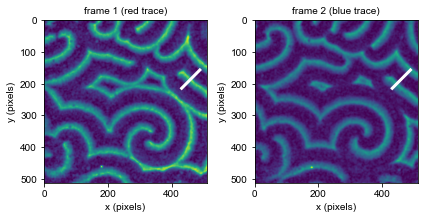

44


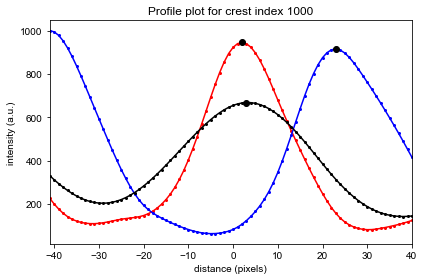

In [15]:
# show position of profile to be displayed on the image
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(im0_raw)
ax1.plot(xxgrid[crest_index], yygrid[crest_index], color="white", linewidth=3)
ax1.set_title("frame 1 (red trace)", fontsize=10)
ax1.set_xlabel("x (pixels)")
ax1.set_ylabel("y (pixels)")
ax2.set_title("frame 2 (blue trace)", fontsize=10)
ax2.imshow(im1_raw)
ax2.plot(xxgrid[crest_index], yygrid[crest_index], color="white", linewidth=3)
ax2.set_xlabel("x (pixels)")
ax2.set_ylabel("y (pixels)")
fig.tight_layout()

if save:
    fig.set_size_inches(9 * cm, 5 * cm)
    fig.tight_layout()
    fig.savefig(
        f"save_output/crestpoint_bias_image_comp.png", dpi=save_dpi, transparent=True
    )
plt.show()

# identify peak positions for this particular crest location
prf1 = profile_map1[crest_index, :]
prf2 = profile_map2[crest_index, :]
peak_shift, x1, y1, x2, y2 = min_de_patterns_crests.compare_profiles(
    prf1, prf2, sampling_width, look_ahead=1, return_peaks=True
)
# for comaparison, the crest position itself:
prf3 = profile_map3[crest_index, :]
iix1 = peak_profile.get_maxima(prf3, 3)
if len(iix1) > 1:
    mid_ii = len(prf1) / 2
    df = abs(iix1 - mid_ii)
    ix1 = iix1[df.argmin(axis=0)]
elif len(iix1) == 1:
    ix1 = iix1[0]
elif len(iix1) == 0:
    ix1 = np.nan
print(iix1[0])
x3 = iix1[0]
y3 = prf3[iix1[0]]


# create shifted axis to have first peak close to center and plot
x_axis_shift = np.arange(-halfspan, halfspan, sampling_width)

# plot example profile
fig, ax = plt.subplots()
ax.set_title(f"Profile plot for crest index {crest_index}")
ax.plot(x_axis_shift, prf1, "ro-", markersize=2)
ax.plot(x_axis_shift, prf2, "bo-", markersize=2)
ax.plot(x1 * sampling_width - halfspan, y1, "ko", markersize=6)
ax.plot(x2 * sampling_width - halfspan, y2, "ko", markersize=6)
ax.plot(x_axis_shift, prf3, "ko-", markersize=2)
ax.plot(x3 * sampling_width - halfspan, y3, "ko", markersize=6)

ax.set_xlabel("distance (pixels)")
ax.set_ylabel("intensity (a.u.)")
ax.set_xlim([-halfspan, halfspan - sampling_width])
fig.tight_layout()

if save:
    fig.set_size_inches(9 * cm, 5 * cm)
    fig.tight_layout()
    fig.savefig(
        f"save_output/crestpoint_bias_image_profiles.png",
        dpi=save_dpi,
        transparent=True,
    )
plt.show()

## Variation in crest points
The analysis routine presented so far can be performed for all pairs of frames within a given image stack. Collecting these results yields a distribution of crest points and associated data, such as the above peak shifts. 

In [16]:
(
    all_velocities,
    all_forward_wavevector_x,
    all_forward_wavevector_y,
    all_wheels,
    all_crests_x,
    all_crests_y,
    all_framenr,
    all_max_x1,
    all_max_y1,
    all_max_x2,
    all_max_y2,
) = local_velocity_analysis(
    MinDE_st_original,
    frames_to_analyse=5,  # use first ... frames
    halfspan=halfspan,
    sampling_width=sampling_width,
    edge=40,  # width of velocity wheel (2D histogram) and max of magnitude histogram
    bins_wheel=40,  # number of bins (horizontal/vertical) for velocity wheel (2D histogram)
    binwidth_sum=2.5,  # binwidth for velocity mangitude histogram
    kernel_size_general=kernel_size_general,  # kernel for first smoothing step
    kernel_size_flow=kernel_size_flow,  # kernel for additional smoothing step
    look_ahead=1,  # 1 -> look in propagation direction, -1 -> against it
    demo=False,  # True -> return figure handles
)

Analysing 5 frames
Working frame 0 to 1
Working frame 1 to 2
Working frame 2 to 3
Working frame 3 to 4


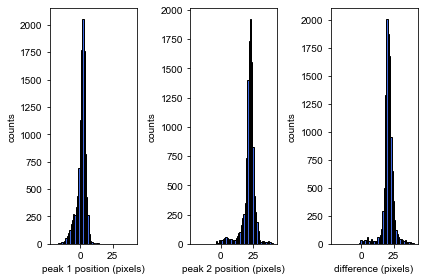

In [17]:
fig, (ax_peak1, ax_peak2, ax_peak3) = plt.subplots(1, 3)
ax_peak1.hist(
    all_max_x1 * sampling_width - halfspan,
    bins=np.arange(-halfspan / 2, halfspan, 1),
    color="royalblue",
    edgecolor="black",
)
ax_peak1.set_ylabel("counts")
ax_peak1.set_xlabel("peak 1 position (pixels)")

ax_peak2.hist(
    all_max_x2 * sampling_width - halfspan,
    bins=np.arange(-halfspan / 2, halfspan, 1),
    color="royalblue",
    edgecolor="black",
)
ax_peak2.set_ylabel("counts")
ax_peak2.set_xlabel("peak 2 position (pixels)")
fig.tight_layout()

ax_peak3.hist(
    (all_max_x2 - all_max_x1) * sampling_width,
    bins=np.arange(-halfspan / 2, halfspan, 1),
    color="royalblue",
    edgecolor="black",
)
ax_peak3.set_ylabel("counts")
ax_peak3.set_xlabel("difference (pixels)")
fig.tight_layout()

if save:
    fig.set_size_inches(18 * cm, 5 * cm)
    fig.tight_layout()
    fig.savefig(
        f"save_output/crestpoint_bias_histograms.png", dpi=save_dpi, transparent=True
    )
plt.show()

In [18]:
# some extra numbers
# first peak
binwidth = 1
bins = np.arange(-halfspan / 2, halfspan, binwidth)
(hist_prf0, bin_edges) = np.histogram(all_max_x1 * sampling_width - halfspan, bins)
pk0 = peak_profile.get_maxima(hist_prf0, N_max=1)
fwhm0 = peak_profile.get_FWHM(hist_prf0, pk0[0])
pk_pix0 = bins[pk0[0]]
fwhm_pix0 = fwhm0 * binwidth

# shift
(hist_prf1, bin_edges) = np.histogram((all_max_x2 - all_max_x1) * sampling_width, bins)
pk1 = peak_profile.get_maxima(hist_prf1, N_max=1)
fwhm1 = peak_profile.get_FWHM(hist_prf1, pk1[0])
pk_pix1 = pk1[0] * binwidth - halfspan / 2
fwhm_pix1 = fwhm1 * binwidth

print("kernel_size_flow:", kernel_size_flow)
print("peak 1, peak position:", pk_pix0)
print("peak 1, fwhm:", fwhm_pix0)
print("shift, peak position:", pk_pix1)
print("shift, fwhm:", fwhm_pix1)

kernel_size_flow: 35
peak 1, peak position: 1.5
peak 1, fwhm: 5
shift, peak position: 19.5
shift, fwhm: 5


## Results

The following table lists the peak distributions as a function of smoothing:

kernel |peak 1 pos | peak 1 FWHM | peak shift | peak FWHM
-------|-----------|-------------|------------|---------- 
10|1.5|2|19.5|6
20|1.5|3|19.5|5
30|1.5|3|19.5|5
40|1.5|4|19.5|6
50|2.5|7|19.5|6
60|1.5|19|20.5|5
